In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import zipfile
with zipfile.ZipFile('/content/gdrive/My Drive/ashrae_data/ashrae-energy-prediction.zip',"r") as zip_ref:
    zip_ref.extractall('/content/gdrive/My Drive/ashrae_data/zipped_data')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-0b4e519f1386>", line 3, in <module>
    zip_ref.extractall('/content/gdrive/My Drive/ashrae_data/zipped_data')
  File "/usr/lib/python3.6/zipfile.py", line 1524, in extractall
    self._extract_member(zipinfo, path, pwd)
  File "/usr/lib/python3.6/zipfile.py", line 1577, in _extract_member
    with self.open(member, pwd=pwd) as source, \
  File "/usr/lib/python3.6/zipfile.py", line 1391, in open
    fheader = zef_file.read(sizeFileHeader)
  File "/usr/lib/python3.6/zipfile.py", line 729, in read
    data = self._file.read(n)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._

KeyboardInterrupt: ignored

In [0]:
!ls '/content/gdrive/My Drive/ashrae_data/zipped_data'

building_metadata.csv  test.csv   weather_test.csv
sample_submission.csv  train.csv  weather_train.csv


In [0]:
path='/content/gdrive/My Drive/ashrae_data/zipped_data'  
train_path=path+"/train.csv"
test_path=path+"/test.csv"
building_metadata_path=path+"/building_metadata.csv"
weather_train_path=path+"/weather_train.csv"
weather_test_path=path+"/weather_test.csv"

train=pd.read_csv(train_path)
test=pd.read_csv(test_path)
building_metadata=pd.read_csv(building_metadata_path)
weather_train=pd.read_csv(weather_train_path)
weather_test=pd.read_csv(weather_test_path)

In [0]:
#function to reduce the memory usage
def reduce_mem_usage(df):
    """ 
    iterate through all the columns of a dataframe and 
    modify the data type to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print(('Memory usage of dataframe is {:.2f}' 
                     'MB').format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max <\
                  np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max <\
                   np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max <\
                   np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max <\
                   np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max <\
                   np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max <\
                   np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print(('Memory usage after optimization is: {:.2f}' 
                              'MB').format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) 
                                             / start_mem))
    
    return df

In [82]:
train=reduce_mem_usage(train)
test=reduce_mem_usage(test)
building_metadata=reduce_mem_usage(building_metadata)
weather_train=reduce_mem_usage(weather_train)
weather_test=reduce_mem_usage(weather_test)

weather_train['timestamp']=pd.to_datetime(weather_train["timestamp"], format='%Y-%m-%d %H:%M:%S')
weather_test['timestamp']=pd.to_datetime(weather_test["timestamp"], format='%Y-%m-%d %H:%M:%S')
train['timestamp']=pd.to_datetime(train["timestamp"], format='%Y-%m-%d %H:%M:%S')
test['timestamp']=pd.to_datetime(test["timestamp"], format='%Y-%m-%d %H:%M:%S')

Memory usage of dataframe is 616.95MB
Memory usage after optimization is: 173.90MB
Decreased by 71.8%
Memory usage of dataframe is 1272.51MB
Memory usage after optimization is: 358.65MB
Decreased by 71.8%
Memory usage of dataframe is 0.07MB
Memory usage after optimization is: 0.02MB
Decreased by 73.8%
Memory usage of dataframe is 9.60MB
Memory usage after optimization is: 2.65MB
Decreased by 72.4%
Memory usage of dataframe is 19.04MB
Memory usage after optimization is: 5.25MB
Decreased by 72.4%


In [0]:
train.timestamp=train.timestamp.astype(weather_train.timestamp.dtype)
test.timestamp=test.timestamp.astype(weather_test.timestamp.dtype)

In [0]:
# let's start by examining the missing values
def missing_values(df):
    ret=pd.DataFrame()
    ret["n_missing_values"]=df.isnull().sum()
    ret["percentage"]=(df.isnull().sum()/df.shape[0])*100
    return(ret)

In [8]:
print(missing_values(train))
print(missing_values(test))

               n_missing_values  percentage
building_id                   0         0.0
meter                         0         0.0
timestamp                     0         0.0
meter_reading                 0         0.0
             n_missing_values  percentage
row_id                      0         0.0
building_id                 0         0.0
meter                       0         0.0
timestamp                   0         0.0


In [9]:
print(missing_values(weather_train))
print(missing_values(weather_test))

                    n_missing_values  percentage
site_id                            0    0.000000
timestamp                          0    0.000000
air_temperature                   55    0.039350
cloud_coverage                 69173   49.489529
dew_temperature                  113    0.080845
precip_depth_1_hr              50289   35.979052
sea_level_pressure             10618    7.596603
wind_direction                  6268    4.484414
wind_speed                       304    0.217496
                    n_missing_values  percentage
site_id                            0    0.000000
timestamp                          0    0.000000
air_temperature                  104    0.037512
cloud_coverage                140448   50.658808
dew_temperature                  327    0.117947
precip_depth_1_hr              95588   34.478057
sea_level_pressure             21265    7.670167
wind_direction                 12370    4.461790
wind_speed                       460    0.165919


In [0]:
#cloud_coverage and precip_depth_1_hr,sea_level_pressure,wind_direction will be dropped because of the high number of missing values

In [0]:
weather_train.drop(columns=["cloud_coverage","precip_depth_1_hr","sea_level_pressure","wind_direction"],axis=0,inplace=True)
weather_test.drop(columns=["cloud_coverage","precip_depth_1_hr","sea_level_pressure","wind_direction"],axis=0,inplace=True)

In [12]:
print(missing_values(building_metadata))

             n_missing_values  percentage
site_id                     0    0.000000
building_id                 0    0.000000
primary_use                 0    0.000000
square_feet                 0    0.000000
year_built                774   53.416149
floor_count              1094   75.500345


In [0]:
# we also will be dropping year_built and floor_count in the building_metadata dataframe

In [0]:
building_metadata.drop(columns=["year_built","floor_count"],axis=0,inplace=True)

## Correlations:


In [83]:
# Find correlations with the target and sort
correlations = train.corr()['meter_reading'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 building_id      0.008761
meter            0.017672
meter_reading    1.000000
Name: meter_reading, dtype: float64

Most Negative Correlations:
 building_id      0.008761
meter            0.017672
meter_reading    1.000000
Name: meter_reading, dtype: float64


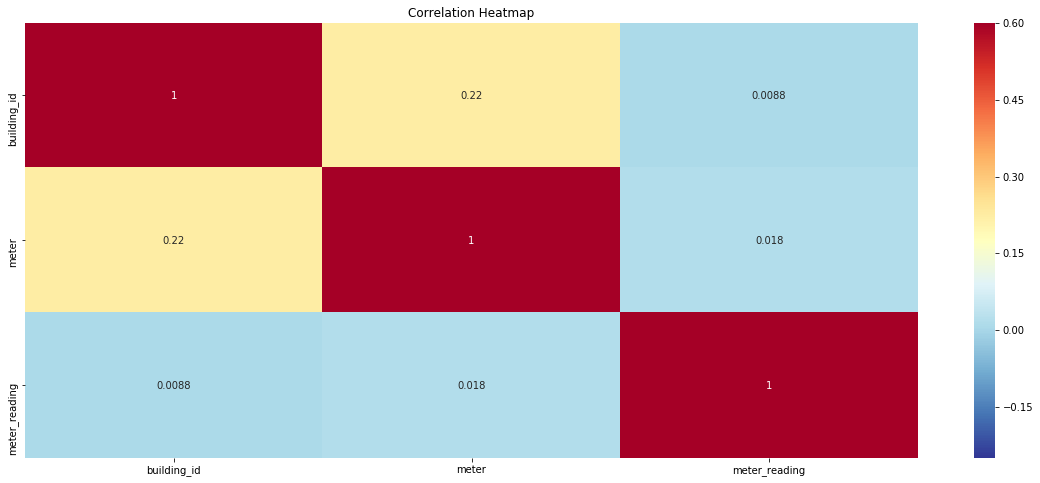

In [86]:
corrs = train.corr()
plt.figure(figsize = (20, 8))

# Heatmap of correlations
sns.heatmap(corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

## Ploting:

In [0]:
#plot dist curves for train and test weather data
def plot_dist_col(column):
  
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.distplot(weather_train[column].dropna(), color='green', ax=ax).set_title(column, fontsize=16)
    sns.distplot(weather_test[column].dropna(), color='purple', ax=ax).set_title(column, fontsize=16)
    plt.xlabel(column, fontsize=15)
    plt.legend(['train', 'test'])
    plt.show()

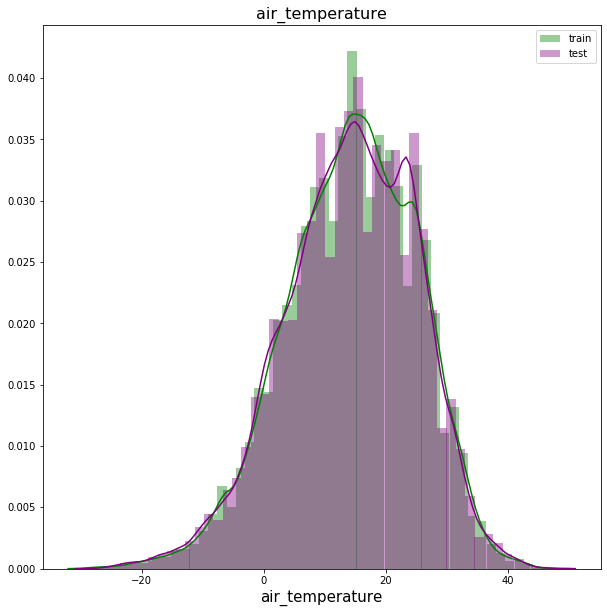

In [88]:
#plot dist. curves for train and test weather data for air_temperature
plot_dist_col('air_temperature')

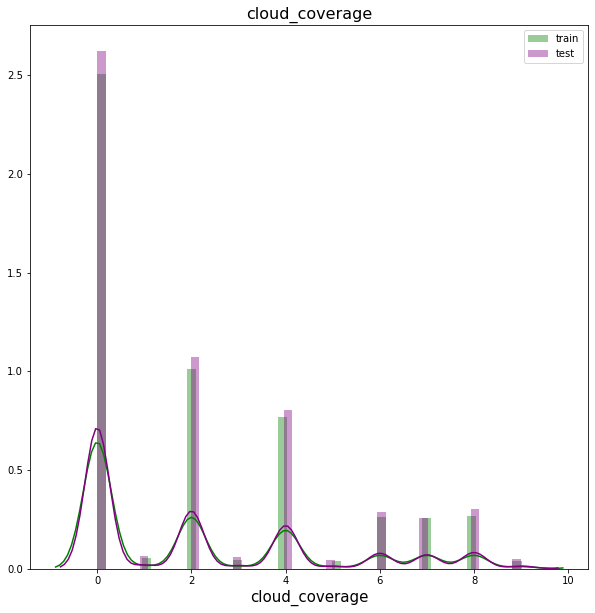

In [90]:
#cloud coverage
plot_dist_col('cloud_coverage')

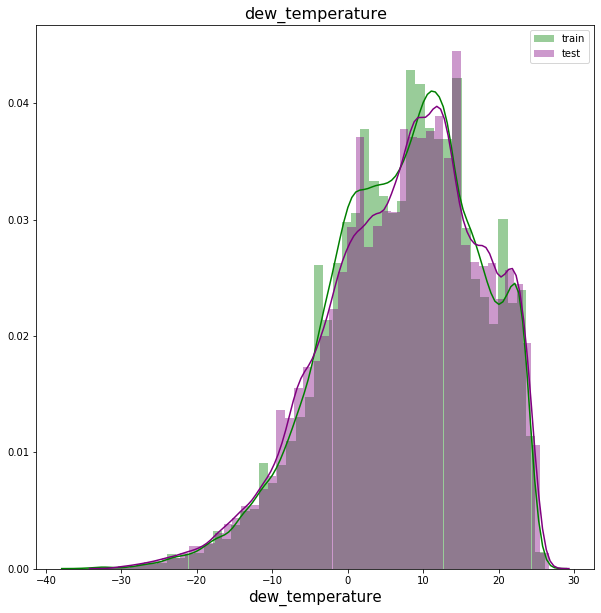

In [91]:
#dew temperature
plot_dist_col('dew_temperature')

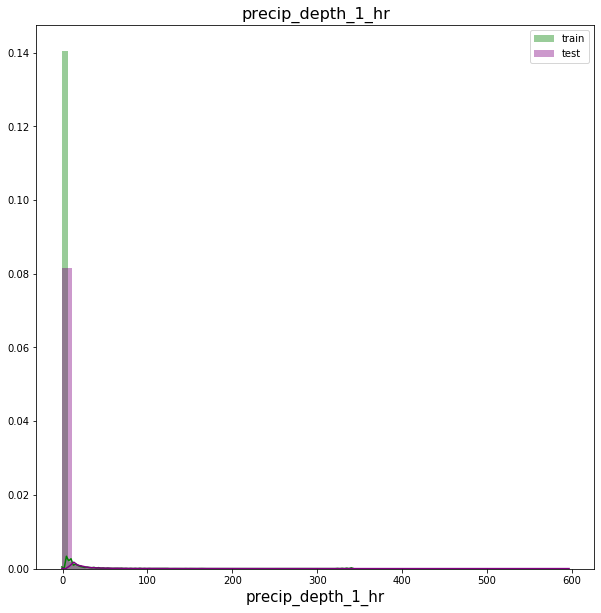

In [92]:
#precip_depth_1_hr

plot_dist_col('precip_depth_1_hr')



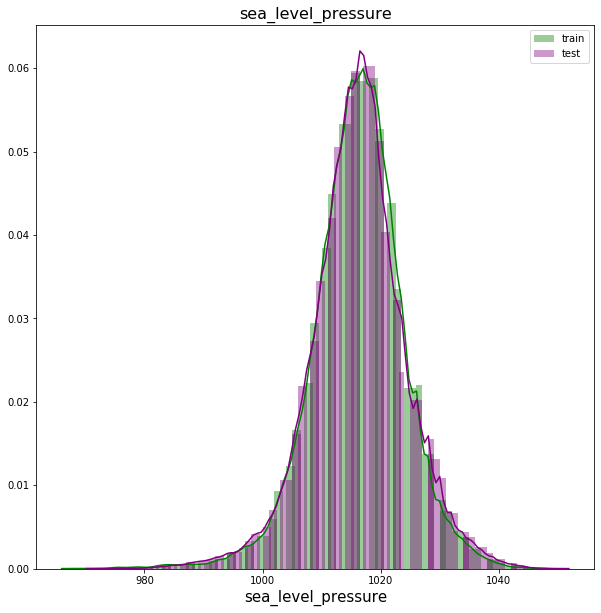

In [93]:
#sea_level_pressure
plot_dist_col('sea_level_pressure')

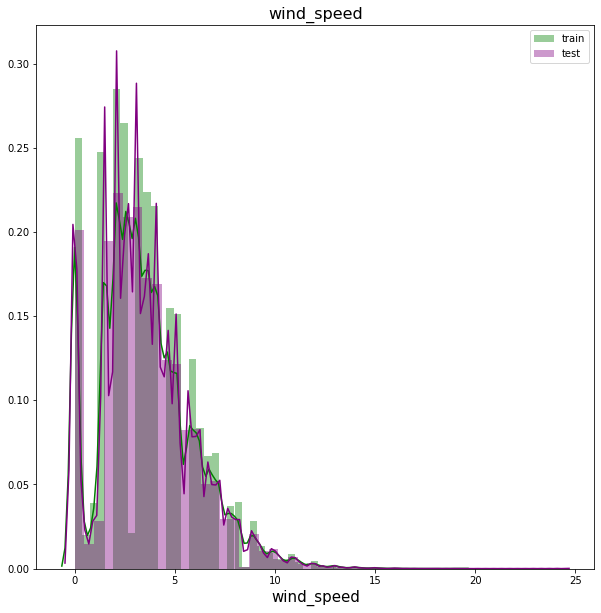

In [94]:
#wind_speed
plot_dist_col('wind_speed')

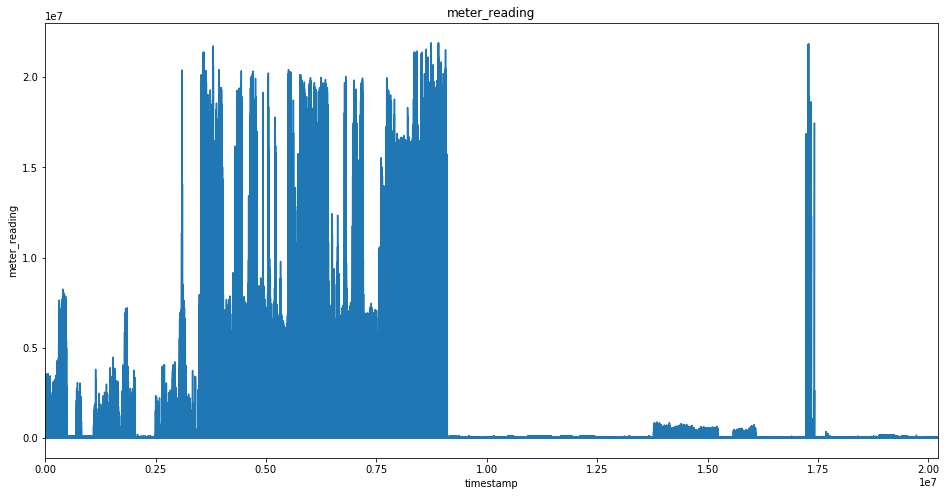

In [96]:
#plotting the target across time
plt.figure(figsize=(16,8))
plt.title('meter_reading')
plt.xlabel('timestamp')
plt.ylabel('meter_reading')
train.meter_reading.plot()

## Dealing with missing values:

In [0]:
# There were some missing hours for some buildings. Those hours have to be created.

In [15]:
weather_train.head()

,site_id,timestamp,air_temperature,dew_temperature,wind_speed
0,0,2016-01-01 00:00:00,25.000000,20.00000,0.000000
1,0,2016-01-01 01:00:00,24.406250,21.09375,1.500000
2,0,2016-01-01 02:00:00,22.796875,21.09375,0.000000
3,0,2016-01-01 03:00:00,21.093750,20.59375,0.000000
4,0,2016-01-01 04:00:00,20.000000,20.00000,2.599609


In [16]:
print("Training Weather Set Time Period =",weather_train.timestamp.min(),"-",weather_train.timestamp.max())

Training Weather Set Time Period = 2016-01-01 00:00:00 - 2016-12-31 23:00:00


In [17]:
print("Testing Weather Set Time Period =",weather_test.timestamp.min(),"-",weather_test.timestamp.max())

Testing Weather Set Time Period = 2017-01-01 00:00:00 - 2018-12-31 23:00:00


In [0]:
# Let's concatenate the weather dataframes and fill the missing hours
# Those hours have to be created in order to make rolling features consistent
df_weather = pd.concat([weather_train, weather_test], ignore_index=True)

In [19]:
df_weather.shape

(417016, 5)

In [0]:
timestamps=pd.date_range(start='2016-01-01 00:00:00', end='2018-12-31 23:00:00', freq='H')

In [0]:
timestamps=pd.date_range(start='2016-01-01 00:00:00', end='2018-12-31 23:00:00', freq='H')
sites_ids=sorted(np.unique(df_weather.site_id))
index = pd.MultiIndex.from_product([sites_ids, timestamps], names = ["site_id", "timestamp"])
new_weather=pd.DataFrame(index=index).reset_index()
df_weather=pd.merge(left=new_weather,right=df_weather,how="left",left_on=["site_id","timestamp"],right_on=["site_id","timestamp"])

In [0]:
# Categorical date and time features
df_weather['HourOfDay'] = df_weather['timestamp'].dt.hour.values.astype(np.uint8)
df_weather['DayOfWeek'] = df_weather['timestamp'].dt.dayofweek.values.astype(np.uint8)
df_weather['DayOfMonth'] = df_weather['timestamp'].dt.day.values.astype(np.uint8)
df_weather['DayOfYear'] = df_weather['timestamp'].dt.dayofyear.values.astype(np.uint16)
df_weather['WeekOfYear'] = (np.floor(df_weather['DayOfYear'] / 7) + 1).astype(np.uint8) # Series.dt.weekofyear is not correct: https://github.com/pandas-dev/pandas/issues/6936
df_weather['MonthOfYear'] = df_weather['timestamp'].dt.month.values.astype(np.uint8)
df_weather['Year'] = df_weather['timestamp'].dt.year.astype(np.uint16)

# Continuous date and time features
df_weather['Hour'] = ((pd.to_timedelta(df_weather['timestamp'] - df_weather['timestamp'].min()).dt.total_seconds().astype('int64')) / 3600).astype(np.uint16)
df_weather['Day'] = (df_weather['Hour'] / 24).astype(np.uint16)
df_weather['Week'] = (df_weather['Day'] / 7).astype(np.uint8)

In [23]:
df_weather.isnull().sum()

site_id               0
timestamp             0
air_temperature    4007
dew_temperature    4288
wind_speed         4612
HourOfDay             0
DayOfWeek             0
DayOfMonth            0
DayOfYear             0
WeekOfYear            0
MonthOfYear           0
Year                  0
Hour                  0
Day                   0
Week                  0
dtype: int64

In [0]:
# using these time features, we will train a lightgbm model to predict the missing weather features
# air_temperature, dew_temperature and wind_speed  are selected because they have the least number of missing values.

In [0]:
import lightgbm as lgb
def nan_imputer(col, window=24):
    
    WEATHER_PREDICTORS = ['HourOfDay', 'DayOfYear', 'WeekOfYear', 'MonthOfYear',  'Year', 'site_id', 
                          f'Site_{col}_RollingBackMean', f'Site_{col}_RollingForwMean', f'SiteHourOfDay_{col}_RollingBackMean', f'SiteHourOfDay_{col}_RollingForwMean']
    df = df_weather.copy()
    
    imputer = lgb.LGBMRegressor(
        learning_rate=0.05,
        objective='mae',
        n_estimators=350,
        num_leaves=31,
        max_depth=8,
        subsample=0.8,
        min_child_samples=50
        
    )    
    
    df[f'Site_{col}_RollingBackMean'] = df.groupby('site_id')[col].rolling(window=window, min_periods=1).mean().interpolate().values
    df[f'Site_{col}_RollingForwMean'] = df.iloc[::-1].groupby('site_id')[col].rolling(window=window, min_periods=1).mean().interpolate().values
    df[f'SiteHourOfDay_{col}_RollingBackMean'] = df.groupby(by=['site_id', 'HourOfDay'])[col].rolling(window=3, min_periods=1).mean().interpolate().values
    df[f'SiteHourOfDay_{col}_RollingForwMean'] = df.iloc[::-1].groupby(by=['site_id', 'HourOfDay'])[col].rolling(window=3, min_periods=1).mean().interpolate().values
    
    trn_idx, missing_idx = ~df[col].isnull(), df[col].isnull()    
    imputer.fit(X=df.loc[trn_idx, WEATHER_PREDICTORS], y=df.loc[trn_idx, col], categorical_feature=['site_id', 'Year'])
    
    df[f'{col}_Restored'] = df[col].copy()
    df.loc[missing_idx, f'{col}_Restored'] = imputer.predict(df.loc[missing_idx, WEATHER_PREDICTORS])
    
    lgb.plot_importance(imputer)
    plt.title(f'{col} Imputation Feature Importance')
    
    return df[f'{col}_Restored'].values.astype(np.float32)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Year', 'site_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


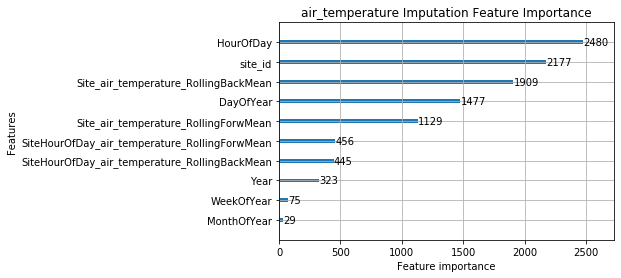

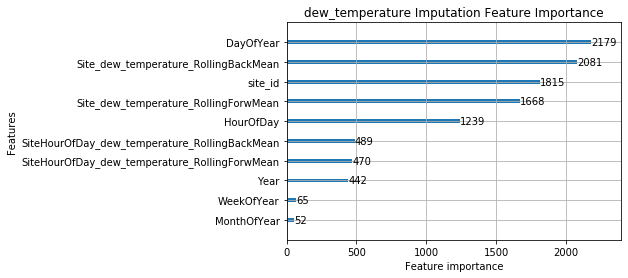

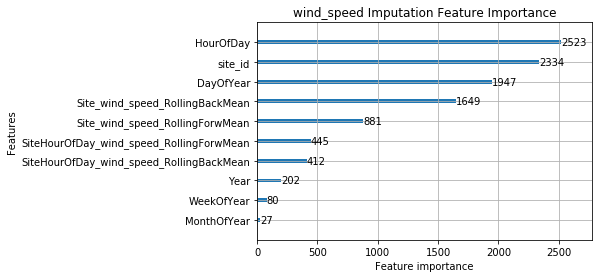

In [26]:
df_weather['air_temperature'] = nan_imputer('air_temperature')
df_weather['dew_temperature'] = nan_imputer('dew_temperature')
df_weather['wind_speed'] = nan_imputer('wind_speed')

In [0]:
# let's drop the least important time features 
df_weather.drop(columns=['DayOfMonth', 'WeekOfYear', 'MonthOfYear', 'Year', 'Hour', 'Day', 'Week'], inplace=True)

In [28]:
df_weather.head()

,site_id,timestamp,air_temperature,dew_temperature,wind_speed,HourOfDay,DayOfWeek,DayOfYear
0,0,2016-01-01 00:00:00,25.000000,20.00000,0.000000,0,4,1
1,0,2016-01-01 01:00:00,24.406250,21.09375,1.500000,1,4,1
2,0,2016-01-01 02:00:00,22.796875,21.09375,0.000000,2,4,1
3,0,2016-01-01 03:00:00,21.093750,20.59375,0.000000,3,4,1
4,0,2016-01-01 04:00:00,20.000000,20.00000,2.599609,4,4,1


## Some feature engineering:


 based on the discussion of the competition :
    England (site 1, site 5)
    Ireland (site 12)
    Canada (site 7, site 11)
    United States (site 0, site 2, site 3, site 4, site 6, site 8, site 9, site 10, site 13, site 14, site 15)
 We will create a feature indicating wheather it is a holiday at a given timestamp, energy consumption tend to reduce during holidays, because building like schools or work buildings are empty.


In [0]:
import holidays
en_holidays = holidays.England()
ir_holidays = holidays.Ireland()
ca_holidays = holidays.Canada()
us_holidays = holidays.UnitedStates()

en_idx = df_weather.query('site_id == 1 or site_id == 5').index
ir_idx = df_weather.query('site_id == 12').index
ca_idx = df_weather.query('site_id == 7 or site_id == 11').index
us_idx = df_weather.query('site_id == 0 or site_id == 2 or site_id == 3 or site_id == 4 or site_id == 6 or site_id == 8 or site_id == 9 or site_id == 10 or site_id == 13 or site_id == 14 or site_id == 15').index

df_weather['IsHoliday'] = 0
df_weather.loc[en_idx, 'IsHoliday'] = df_weather.loc[en_idx, 'timestamp'].apply(lambda x: en_holidays.get(x, default=0))
df_weather.loc[ir_idx, 'IsHoliday'] = df_weather.loc[ir_idx, 'timestamp'].apply(lambda x: ir_holidays.get(x, default=0))
df_weather.loc[ca_idx, 'IsHoliday'] = df_weather.loc[ca_idx, 'timestamp'].apply(lambda x: ca_holidays.get(x, default=0))
df_weather.loc[us_idx, 'IsHoliday'] = df_weather.loc[us_idx, 'timestamp'].apply(lambda x: us_holidays.get(x, default=0))

holiday_idx = df_weather['IsHoliday'] != 0
df_weather.loc[holiday_idx, 'IsHoliday'] = 1
df_weather['IsHoliday'] = df_weather['IsHoliday'].astype(np.uint8)

Let's create a train and test dataframe, every building must have 4 meter_reading values corresponding to to each meter type
for every timestamp

In [30]:
print(train.head())
print(train.shape)

   building_id  meter  timestamp  meter_reading
0            0      0 2016-01-01            0.0
1            1      0 2016-01-01            0.0
2            2      0 2016-01-01            0.0
3            3      0 2016-01-01            0.0
4            4      0 2016-01-01            0.0
(20216100, 4)


In [0]:
timestamps_train=pd.date_range(start=train.timestamp.min(), end=train.timestamp.max(), freq='H')
timestamps_test=pd.date_range(start=test.timestamp.min(), end=test.timestamp.max(), freq='H')
building_ids=sorted(np.unique(train.building_id))
meters=sorted(np.unique(train.meter))
indx_train = pd.MultiIndex.from_product([building_ids, timestamps_train,meters], names = ["building_id", "timestamp","meter"])
indx_test = pd.MultiIndex.from_product([building_ids, timestamps_test,meters], names = ["building_id", "timestamp","meter"])
new_train=pd.DataFrame(index=indx_train).reset_index()
new_test=pd.DataFrame(index=indx_test).reset_index()


In [0]:
new_train=pd.merge(left=new_train,right=train,how="left",left_on=["building_id", "timestamp","meter"],right_on=["building_id", "timestamp","meter"])
new_test=pd.merge(left=new_test,right=test,how="left",left_on=["building_id", "timestamp","meter"],right_on=["building_id", "timestamp","meter"])

In [33]:
new_test.head()

,building_id,timestamp,meter,row_id
0,0,2017-01-01 00:00:00,0,0.0
1,0,2017-01-01 00:00:00,1,NaN
2,0,2017-01-01 00:00:00,2,NaN
3,0,2017-01-01 00:00:00,3,NaN
4,0,2017-01-01 01:00:00,0,129.0


In [0]:
new_train=pd.merge(left=new_train,right=building_metadata,how="left",left_on=["building_id"],right_on=["building_id"])
new_test=pd.merge(left=new_test,right=building_metadata,how="left",left_on=["building_id"],right_on=["building_id"])

In [35]:
new_train.head()

,building_id,timestamp,meter,meter_reading,site_id,primary_use,square_feet
0,0,2016-01-01 00:00:00,0,0.0,0,Education,7432
1,0,2016-01-01 00:00:00,1,NaN,0,Education,7432
2,0,2016-01-01 00:00:00,2,NaN,0,Education,7432
3,0,2016-01-01 00:00:00,3,NaN,0,Education,7432
4,0,2016-01-01 01:00:00,0,0.0,0,Education,7432


In [0]:
new_train.meter_reading.fillna(-1,inplace=True)

In [37]:
df_weather.head()

,site_id,timestamp,air_temperature,dew_temperature,wind_speed,HourOfDay,DayOfWeek,DayOfYear,IsHoliday
0,0,2016-01-01 00:00:00,25.000000,20.00000,0.000000,0,4,1,1
1,0,2016-01-01 01:00:00,24.406250,21.09375,1.500000,1,4,1,1
2,0,2016-01-01 02:00:00,22.796875,21.09375,0.000000,2,4,1,1
3,0,2016-01-01 03:00:00,21.093750,20.59375,0.000000,3,4,1,1
4,0,2016-01-01 04:00:00,20.000000,20.00000,2.599609,4,4,1,1


In [0]:
new_train=pd.merge(left=new_train,right=df_weather,how="left",left_on=["site_id","timestamp"],right_on=["site_id","timestamp"])
new_test=pd.merge(left=new_test,right=df_weather,how="left",left_on=["site_id","timestamp"],right_on=["site_id","timestamp"])

In [39]:
new_train.head(5)

,building_id,timestamp,meter,meter_reading,site_id,primary_use,square_feet,air_temperature,dew_temperature,wind_speed,HourOfDay,DayOfWeek,DayOfYear,IsHoliday
0,0,2016-01-01 00:00:00,0,0.0,0,Education,7432,25.00000,20.00000,0.0,0,4,1,1
1,0,2016-01-01 00:00:00,1,-1.0,0,Education,7432,25.00000,20.00000,0.0,0,4,1,1
2,0,2016-01-01 00:00:00,2,-1.0,0,Education,7432,25.00000,20.00000,0.0,0,4,1,1
3,0,2016-01-01 00:00:00,3,-1.0,0,Education,7432,25.00000,20.00000,0.0,0,4,1,1
4,0,2016-01-01 01:00:00,0,0.0,0,Education,7432,24.40625,21.09375,1.5,1,4,1,1


Encoding the primary use feature. If we try to onehot encode the primary use, we run out of RAM. That's why we will be using label encoding instead.

In [40]:
! pip install category_encoders
import category_encoders as ce

encoder = ce.OrdinalEncoder(cols=["primary_use"])
encoder.fit(new_train)
new_train=encoder.transform(new_train)
new_test=encoder.transform(new_test)

## preparing the data for the generator

The generator will be fed with a train list, each index of this list represent an id_building. Every element of this list represents the training data for the building during all the timestamps. We also create a target list, each index represent an id_building and every element represents the targets for the building.

In [0]:

data_list=[]
for i in range(new_train.building_id.nunique()):
  data_list.append(new_train[new_train.building_id==i])


In [42]:
data_list[0].head()

,building_id,timestamp,meter,meter_reading,site_id,primary_use,square_feet,air_temperature,dew_temperature,wind_speed,HourOfDay,DayOfWeek,DayOfYear,IsHoliday
0,0,2016-01-01 00:00:00,0,0.0,0,1,7432,25.00000,20.00000,0.0,0,4,1,1
1,0,2016-01-01 00:00:00,1,-1.0,0,1,7432,25.00000,20.00000,0.0,0,4,1,1
2,0,2016-01-01 00:00:00,2,-1.0,0,1,7432,25.00000,20.00000,0.0,0,4,1,1
3,0,2016-01-01 00:00:00,3,-1.0,0,1,7432,25.00000,20.00000,0.0,0,4,1,1
4,0,2016-01-01 01:00:00,0,0.0,0,1,7432,24.40625,21.09375,1.5,1,4,1,1


In [43]:
target_list=[]
for i in data_list:
  target_list.append(i.meter_reading.copy())
  

for i in data_list:
  i.drop(columns=["timestamp","meter_reading","meter"],axis=0,inplace=True)
  i.drop_duplicates(inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
for i in range(len(data_list)):
  data_list[i]=data_list[i].values

data_list=np.array(data_list).reshape((1449*8784,11))
from sklearn.preprocessing import StandardScaler,MinMaxScaler
scaler = MinMaxScaler(feature_range=(-0.5, 0.5))
scaler.fit(data_list)
data_list=scaler.transform(data_list)
data_list=data_list.reshape((1449,8784,11))


In [45]:
len(target_list)

1449

In [46]:
target_list=np.array(target_list)
target_list=target_list.reshape((1449*35136,1))
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler.fit(target_list)
target_list=target_scaler.transform(target_list)
target_list=target_list.reshape((1449,35136))
print(target_list.shape)


(1449, 35136)


In [47]:
n_buildings=new_train.building_id.nunique()
print(n_buildings)

1449


In [52]:
data_list[0].shape

(8784, 11)

In [0]:
global r
r=0

Creating the generator. The generator will generate batches for size=128. Every row represents features for a building starting from a random timestamp. The first row will contain informations about the building whose id=0, second row id=1 ext...

In [0]:
def generator(data_list,target_list,n_buildings, lookback, delay, min_index, max_index, 
             shuffle=False, batch_size=128, step=1):
    """
    data—The original array of floating-point data, which you normalized.
    lookback—How many timesteps back the input data should go.
    delay—How many timesteps in the future the target should be.
    min_index and max_index—Indices in the data array that delimit which timesteps to draw from. 
                            This is useful for keeping a segment of the data for validation and another for testing.
    shuffle—Whether to shuffle the samples or draw them in chronological order.
    batch_size—The number of samples per batch.
    step—The period, in timesteps, at which you sample data. You’ll set it 6 in order to draw one data point every hour.
    
    """
    global r
    if max_index is None:
        max_index = len(data_list[0]) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                    min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                            lookback // step,
                            data_list[0].shape[-1]))
        targets = np.zeros((len(rows),lookback // step,4))

        for j, row in enumerate(rows):
            #r=np.random.randint(low=0,high=n_buildings)
            r=r%n_buildings
            indices = range(rows[j] - lookback, rows[j], step)
            indices_target = range((rows[j] - lookback)*4 + delay, rows[j]*4 + delay, step)
            #print(row)
            #print(rows[j])
            #print("//")
            #print("indices", indices)
            samples[j] = data_list[r][indices]
            targets[j] = target_list[r][indices_target].reshape((lookback // step,4))
            #print(r)
            r+=1
            

            
        yield samples, targets

In [55]:
lookback =4320 #observations will go back 6 months = 6*30*24
step = 1  # observations will be sampled at one data point per hour
delay = 1 # targets will be 24 hours in the future
batch_size = 128
n_buildings=new_train.building_id.nunique()
train_gen = generator(data_list,target_list,n_buildings,
                        lookback=lookback,
                        delay=delay,
                        min_index=0,
                        max_index=8783,
                        shuffle=True,
                        step=step,
                        batch_size=batch_size)
"""
val_gen = generator(data_list,target_list,n_buildings,
                        lookback=lookback,
                        delay=delay,
                        min_index=7784,
                        max_index=8783,
                        step=step,
                        batch_size=batch_size)
"""

'\nval_gen = generator(data_list,target_list,n_buildings,\n                        lookback=lookback,\n                        delay=delay,\n                        min_index=7784,\n                        max_index=8783,\n                        step=step,\n                        batch_size=batch_size)\n'

In [136]:
6*30*24

4320

In [0]:
a,b=next(train_gen)

In [139]:
a.shape

(128, 4320, 11)

In [140]:
a[0]

array([[-0.5       , -0.5       , -0.5       , ...,  0.33333333,
        -0.17123288, -0.5       ],
       [-0.5       , -0.5       , -0.5       , ...,  0.33333333,
        -0.17123288, -0.5       ],
       [-0.5       , -0.5       , -0.5       , ...,  0.33333333,
        -0.17123288, -0.5       ],
       ...,
       [-0.5       , -0.5       , -0.5       , ...,  0.        ,
         0.32191781, -0.5       ],
       [-0.5       , -0.5       , -0.5       , ...,  0.        ,
         0.32191781, -0.5       ],
       [-0.5       , -0.5       , -0.5       , ...,  0.        ,
         0.32191781, -0.5       ]])

In [0]:
b[0]

array([[4.56523033e-08, 0.00000000e+00, 4.56523033e-08, 2.49549194e-05],
       [4.56523033e-08, 0.00000000e+00, 4.79349183e-08, 2.34146119e-05],
       [4.56523033e-08, 0.00000000e+00, 4.56523033e-08, 2.34146119e-05],
       ...,
       [2.04344269e-05, 0.00000000e+00, 4.56523033e-08, 2.76757964e-05],
       [4.32751876e-05, 0.00000000e+00, 1.02996164e-05, 2.76757964e-05],
       [4.93487714e-05, 0.00000000e+00, 1.72045275e-05, 2.76757964e-05]])

In [0]:
new_train[new_train.site_id==0].meter_reading.max()

172611.0

## Building the model

In [57]:
from tensorflow.keras.layers import Dense,LSTM,GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras import optimizers

model = Sequential()
model.add(GRU(32, activation='relu', 
               input_shape=(None,data_list[0].shape[-1]), 
               dropout=0.2,
               recurrent_dropout= 0.3,
               return_sequences=True
              ))

model.add(GRU(32, 
               activation='relu', 
               dropout=0.2,
               recurrent_dropout= 0.3,
               return_sequences=True
              ))

model.add(Dense(4,activation="linear"))

model.compile(optimizer=optimizers.Adam(lr=0.0006,clipnorm=1.0), loss="mse")
print(model.summary())

#val_steps = (8783-7784-lookback)//batch_size

callback_checkpoint = ModelCheckpoint(filepath= '/content/gdrive/My Drive/ashrae_data/ashrae_models/model_3.{epoch:02d}.hdf5',
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=False,
                                      save_best_only=False)
"""
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

"""
callbacks = [#callback_early_stopping,
             callback_checkpoint]


history = model.fit_generator(train_gen,
                              steps_per_epoch = 100, 
                              epochs=500, 
                              #validation_data = val_gen, 
                              callbacks=callbacks,
                              verbose=1),
                              #validation_steps = val_steps)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, None, 32)          4224      
_________________________________________________________________
gru_5 (GRU)                  (None, None, 32)          6240      
_________________________________________________________________
dense_2 (Dense)              (None, None, 4)           132       
Total params: 10,596
Trainable params: 10,596
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
 99/100 [============================>.] - ETA: 8s - loss: 0.0019 
Epoch 00001: saving model to /content/gdrive/My Drive/ashrae_data/ashrae_models/model_3.01.hdf5
100/100 [==============================] - 863s 9s/step - loss: 0.0019
Epoch 2/500
 99/100 [============================>.] - ETA: 8s - loss: 3.7101e-04 
Epoch 00002: saving model to /content/gdrive/M

KeyboardInterrupt: ignored

In [0]:
new_train=[]
data_list=[]

In [59]:
new_test.head()

,building_id,timestamp,meter,row_id,site_id,primary_use,square_feet,air_temperature,dew_temperature,wind_speed,HourOfDay,DayOfWeek,DayOfYear,IsHoliday
0,0,2017-01-01 00:00:00,0,0.0,0,1,7432,17.796875,11.703125,3.599609,0,6,1,1
1,0,2017-01-01 00:00:00,1,NaN,0,1,7432,17.796875,11.703125,3.599609,0,6,1,1
2,0,2017-01-01 00:00:00,2,NaN,0,1,7432,17.796875,11.703125,3.599609,0,6,1,1
3,0,2017-01-01 00:00:00,3,NaN,0,1,7432,17.796875,11.703125,3.599609,0,6,1,1
4,0,2017-01-01 01:00:00,0,129.0,0,1,7432,17.796875,12.796875,3.099609,1,6,1,1


In [0]:
pred_list=[]
for i in range(new_test.building_id.nunique()):
  pred_list.append(new_test[new_test.building_id==i])

In [0]:
del(new_test)
del(new_train)


In [0]:
row_ids=[]
for i in pred_list:
  row_ids.append(i.row_id.copy())

In [0]:
for i in pred_list:
  i.drop(columns=["timestamp","meter","row_id"],axis=0,inplace=True)
  i.drop_duplicates(inplace=True)

In [0]:
for i in pred_list:
  i.drop_duplicates(inplace=True)

In [65]:
pred_list[0].shape

(17520, 11)

In [0]:
for i in range(len(pred_list)):
  pred_list[i]=pred_list[i].values

pred_list=np.array(pred_list).reshape((1449*17520,11))

pred_list=scaler.transform(pred_list)
pred_list=pred_list.reshape((1449,17520,11))

In [0]:
from tensorflow.keras.models import load_model
model=load_model('/content/gdrive/My Drive/ashrae_data/ashrae_models/model_2.26-0.00.hdf5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
predictions=model.predict(pred_list)

In [0]:
predictions.shape

(1449, 17520, 4)

In [0]:
predictions=predictions.reshape((1449,17520*4))
predictions=target_scaler.inverse_transform(predictions)
predictions=predictions.reshape((1449,17520,4))


In [0]:
predictions=predictions.reshape((1449,17520*4))

In [0]:
row_ids=np.array(row_ids)

In [71]:
row_ids.shape

(1449, 70080)

In [0]:
predictions=predictions.reshape((predictions.shape[0]*predictions.shape[1],1))

In [0]:
row_ids=row_ids.reshape((row_ids.shape[0]*row_ids.shape[1],1))

In [74]:
print(predictions.shape)
print(row_ids.shape)

(101545920, 1)
(101545920, 1)


In [0]:
s1=pd.Series(data=predictions[:,0])
s2=pd.Series(data=row_ids[:,0])

In [0]:
sub=pd.DataFrame()
sub["row_id"]=s2
sub["meter_reading"]=s1

In [0]:
sub.dropna(inplace=True)

In [0]:
sub.row_id=sub.row_id.astype("int32")

In [0]:
sub.to_csv(path_or_buf="/content/gdrive/My Drive/ashrae_data/sub3.gz",index=False,compression='gzip')